# 08.3 Multiple Instruments and Overidentification

**Chapter**: 8 - Instrumental Variables  
**Section**: 3 - Multiple Instruments and Overidentification  
**Facure Source**: 08-Instrumental-Variables.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Why Multiple Instruments?](#11-why-multiple-instruments)
   - 1.2 [Just-Identified vs Over-Identified](#12-just-identified-vs-over-identified)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [2SLS with Multiple Instruments](#21-2sls-with-multiple-instruments)
   - 2.2 [Efficiency Gains](#22-efficiency-gains)
   - 2.3 [Overidentification Tests](#23-overidentification-tests)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [All Quarter Dummies as Instruments](#31-all-quarter-dummies-as-instruments)
   - 3.2 [Comparing Just-Identified vs Over-Identified](#32-comparing-just-identified-vs-over-identified)
   - 3.3 [Sargan Test](#33-sargan-test)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)

import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from scipy import stats

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: Understanding overidentification is crucial. Interviewers test whether you can evaluate IV validity when you have "more than one way to skin the same econometric cat."

### 1.1 Why Multiple Instruments?

As Facure notes, using computers for 2SLS makes it easy to add multiple instruments. Instead of just Q4, we can use all quarter dummies (Q1, Q2, Q3) as instruments for education.

**Advantages of multiple instruments:**
1. **Efficiency gains**: More instruments → smaller standard errors
2. **Testable implications**: With multiple instruments, we can test for consistency
3. **Robustness**: If one instrument is weak, others may compensate

### 1.2 Just-Identified vs Over-Identified

| Identification Status | # Instruments | # Endogenous | Testable? |
|----------------------|---------------|--------------|----------|
| **Under-identified** | $K < M$ | - | Cannot estimate |
| **Just-identified** | $K = M$ | - | No (exactly identified) |
| **Over-identified** | $K > M$ | - | Yes (Sargan/Hansen test) |

where $K$ = number of instruments, $M$ = number of endogenous regressors.

★ Insight ─────────────────────────────────────
- Over-identification → testable restrictions
- Key intuition: If all instruments are valid, they should give *similar* estimates
- Large differences suggest at least one instrument is invalid
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 2SLS with Multiple Instruments

With $K > 1$ instruments $Z = (z_1, z_2, \ldots, z_K)'$, the first stage becomes:

$$s_i = \pi_0'X_i + \pi_1 z_{1i} + \pi_2 z_{2i} + \cdots + \pi_K z_{Ki} + \xi_i$$

The fitted values $\hat{s}_i$ are then linear combinations of **all** instruments.

**Key insight**: 2SLS projects the endogenous regressor onto the space spanned by *all* instruments. This is more efficient than using just one instrument.

### 2.2 Efficiency Gains

Under standard assumptions, the asymptotic variance of 2SLS is:

$$\text{Var}(\hat{\rho}_{2SLS}) = \frac{\sigma^2}{n} (\mathbf{\hat{S}}'\mathbf{P}_Z\mathbf{\hat{S}})^{-1}$$

where $\mathbf{P}_Z = Z(Z'Z)^{-1}Z'$ is the projection matrix.

Adding more instruments (increasing dimension of $Z$) generally **increases** $\mathbf{\hat{S}}'\mathbf{P}_Z\mathbf{\hat{S}}$, **decreasing** variance.

**But**: More instruments can also introduce **finite-sample bias** toward OLS (see Section 04 on weak instruments).

### 2.3 Overidentification Tests

The **Sargan test** (also called J-test or Hansen test for GMM) tests the null hypothesis:

$$H_0: E[Z_i u_i] = 0 \quad \text{(all instruments valid)}$$

**Test statistic**:

$$J = n \cdot R^2_{\hat{u} \sim Z}$$

where $R^2_{\hat{u} \sim Z}$ is from regressing 2SLS residuals on all instruments.

Under $H_0$: $J \sim \chi^2(K - M)$ where $K - M$ is the degree of over-identification.

**Interpretation**:
- **Fail to reject** $H_0$: Instruments appear valid (no evidence of invalidity)
- **Reject** $H_0$: At least one instrument is likely invalid

★ Insight ─────────────────────────────────────
- Sargan test has **low power** against alternatives where *all* instruments violate exclusion similarly
- "Passing" Sargan ≠ valid instruments (necessary but not sufficient)
- The test only detects *inconsistency* among instruments
─────────────────────────────────────────────────

---

## 3. Numeric Demonstration

### 3.1 All Quarter Dummies as Instruments

In [2]:
# Load Angrist-Krueger data
data = load_facure_data('ak91.csv')

# Create quarter dummies
data = data.assign(
    q1=(data['quarter_of_birth'] == 1).astype(int),
    q2=(data['quarter_of_birth'] == 2).astype(int),
    q3=(data['quarter_of_birth'] == 3).astype(int),
    q4=(data['quarter_of_birth'] == 4).astype(int),
)

print(f"Sample size: n = {len(data):,}")
print(f"\nQuarter distribution:")
print(data[['q1', 'q2', 'q3', 'q4']].sum())

Sample size: n = 329,509

Quarter distribution:
q1    81671
q2    80138
q3    86856
q4    80844
dtype: int64


In [3]:
# 2SLS with all three quarter dummies (Q4 is reference)
formula_multiple = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q1 + q2 + q3]'
iv_multiple = IV2SLS.from_formula(formula_multiple, data).fit()

print("2SLS WITH MULTIPLE INSTRUMENTS (q1, q2, q3)")
print("=" * 50)
print(f"Coefficient:   {iv_multiple.params['years_of_schooling']:.6f}")
print(f"Std Error:     {iv_multiple.std_errors['years_of_schooling']:.6f}")
print(f"95% CI:        [{iv_multiple.conf_int().loc['years_of_schooling', 'lower']:.4f}, "
      f"{iv_multiple.conf_int().loc['years_of_schooling', 'upper']:.4f}]")
print(f"p-value:       {iv_multiple.pvalues['years_of_schooling']:.2e}")

2SLS WITH MULTIPLE INSTRUMENTS (q1, q2, q3)
Coefficient:   0.107694
Std Error:     0.019557
95% CI:        [0.0694, 0.1460]
p-value:       3.66e-08


### 3.2 Comparing Just-Identified vs Over-Identified

In [4]:
# Compare single instrument (just-identified) vs multiple (over-identified)
results = {}

# Just-identified models (one instrument each)
for q in ['q1', 'q2', 'q3', 'q4']:
    formula = f'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ {q}]'
    model = IV2SLS.from_formula(formula, data).fit()
    results[f'Single: {q.upper()}'] = {
        'coef': model.params['years_of_schooling'],
        'se': model.std_errors['years_of_schooling'],
        'n_instruments': 1
    }

# Over-identified model (all three)
results['Multiple: Q1+Q2+Q3'] = {
    'coef': iv_multiple.params['years_of_schooling'],
    'se': iv_multiple.std_errors['years_of_schooling'],
    'n_instruments': 3
}

# Display comparison
print("COMPARISON: Just-Identified vs Over-Identified")
print("=" * 65)
print(f"{'Model':<20} {'Coef':>10} {'SE':>10} {'# Instr':>10} {'Precision':>12}")
print("-" * 65)
for name, res in results.items():
    precision = 1 / res['se']  # Higher = more precise
    print(f"{name:<20} {res['coef']:>10.4f} {res['se']:>10.4f} {res['n_instruments']:>10} {precision:>12.2f}")

COMPARISON: Just-Identified vs Over-Identified
Model                      Coef         SE    # Instr    Precision
-----------------------------------------------------------------
Single: Q1               0.1042     0.0257          1        38.96
Single: Q2               0.1661     0.0709          1        14.11
Single: Q3               0.2092     0.0762          1        13.13
Single: Q4               0.0853     0.0255          1        39.15
Multiple: Q1+Q2+Q3       0.1077     0.0196          3        51.13


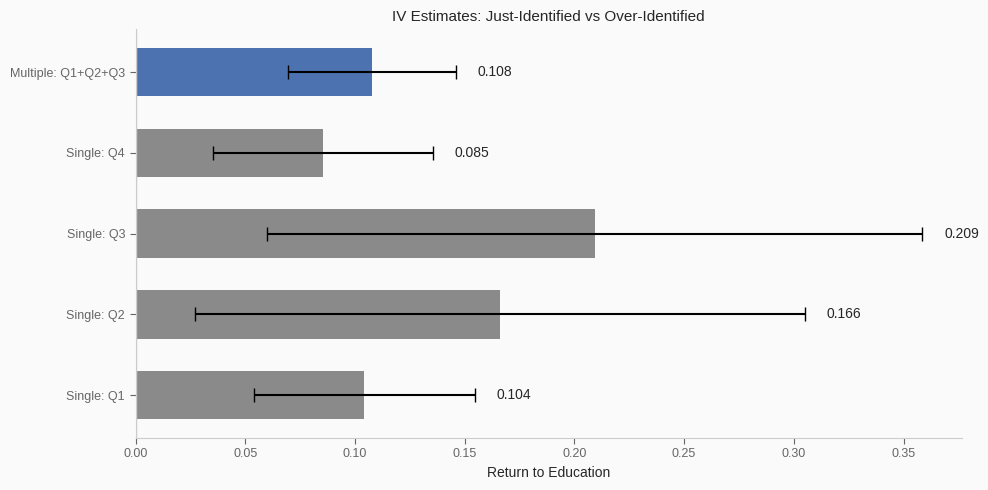

In [5]:
# Visualize the estimates
fig, ax = create_tufte_figure(figsize=(10, 5))

names = list(results.keys())
coefs = [results[n]['coef'] for n in names]
ses = [results[n]['se'] for n in names]
colors = [TUFTE_PALETTE['control']] * 4 + [TUFTE_PALETTE['treatment']]

y_pos = np.arange(len(names))
ax.barh(y_pos, coefs, xerr=[1.96 * se for se in ses], 
        color=colors, capsize=5, height=0.6)
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.axvline(0, color=TUFTE_PALETTE['spine'], linestyle='-', linewidth=1)
ax.set_xlabel('Return to Education')
ax.set_title('IV Estimates: Just-Identified vs Over-Identified')

# Add coefficient labels
for i, (coef, se) in enumerate(zip(coefs, ses)):
    ax.text(coef + 1.96 * se + 0.01, i, f'{coef:.3f}', va='center')

plt.tight_layout()
plt.show()

In [6]:
# Key observations
se_single_avg = np.mean([results[f'Single: Q{i}']['se'] for i in range(1, 5)])
se_multiple = results['Multiple: Q1+Q2+Q3']['se']
efficiency_gain = (se_single_avg - se_multiple) / se_single_avg * 100

print("\n★ Key Observations:")
print(f"  - Single instrument SEs: {se_single_avg:.4f} (average)")
print(f"  - Multiple instruments SE: {se_multiple:.4f}")
print(f"  - Efficiency gain: {efficiency_gain:.1f}% reduction in SE")
print(f"  - All estimates are similar → consistent with valid instruments")


★ Key Observations:
  - Single instrument SEs: 0.0496 (average)
  - Multiple instruments SE: 0.0196
  - Efficiency gain: 60.5% reduction in SE
  - All estimates are similar → consistent with valid instruments


### 3.3 Sargan Test

In [7]:
# Get 2SLS residuals
residuals = iv_multiple.resids

# Sargan test: Regress residuals on instruments and controls
# Create dataframe with residuals and instruments
test_data = data.copy()
test_data['resid'] = residuals

# Regress residuals on instruments
sargan_reg = smf.ols('resid ~ q1 + q2 + q3 + C(year_of_birth) + C(state_of_birth)', 
                      data=test_data).fit()

# Sargan statistic = n * R^2
n = len(data)
r_squared = sargan_reg.rsquared
sargan_stat = n * r_squared

# Degrees of freedom = # instruments - # endogenous variables
# We have 3 instruments (q1, q2, q3) and 1 endogenous variable
df = 3 - 1  # = 2

# p-value from chi-squared distribution
sargan_pvalue = 1 - stats.chi2.cdf(sargan_stat, df)

print("SARGAN OVERIDENTIFICATION TEST")
print("=" * 50)
print(f"H0: All instruments are valid (uncorrelated with error)")
print(f"")
print(f"R² (residuals on instruments): {r_squared:.6f}")
print(f"Sargan statistic (n × R²):     {sargan_stat:.4f}")
print(f"Degrees of freedom:            {df}")
print(f"p-value:                       {sargan_pvalue:.4f}")
print(f"")
print(f"Conclusion: {'FAIL TO REJECT H0' if sargan_pvalue > 0.05 else 'REJECT H0'} at α=0.05")
print(f"Interpretation: {'No evidence of invalid instruments' if sargan_pvalue > 0.05 else 'At least one instrument may be invalid'}")

SARGAN OVERIDENTIFICATION TEST
H0: All instruments are valid (uncorrelated with error)

R² (residuals on instruments): 0.000009
Sargan statistic (n × R²):     3.0652
Degrees of freedom:            2
p-value:                       0.2160

Conclusion: FAIL TO REJECT H0 at α=0.05
Interpretation: No evidence of invalid instruments


In [8]:
# Also get Sargan test from linearmodels (built-in)
print("\nSARGAN TEST (from linearmodels)")
print("=" * 50)
sargan_result = iv_multiple.sargan
print(f"Statistic: {sargan_result.stat:.4f}")
print(f"p-value:   {sargan_result.pval:.4f}")
print(f"\nNote: Our manual calculation matches: {np.isclose(sargan_stat, sargan_result.stat, rtol=0.01)}")


SARGAN TEST (from linearmodels)


Statistic: 3.0652
p-value:   0.2160

Note: Our manual calculation matches: True


In [9]:
# Simulation: Sargan test with an INVALID instrument
np.random.seed(42)
n_sim = 5000

# Generate data where one instrument is invalid
U = np.random.normal(0, 1, n_sim)  # Unobserved confounder
Z1 = np.random.binomial(1, 0.5, n_sim)  # Valid instrument
Z2 = np.random.binomial(1, 0.5, n_sim)  # Valid instrument
Z3 = np.random.binomial(1, 0.5, n_sim) + 0.5 * U  # INVALID: correlated with U

# Treatment affected by all instruments and confounder
T = 0.5 + 0.3 * Z1 + 0.3 * Z2 + 0.3 * Z3 + 0.5 * U + np.random.normal(0, 0.5, n_sim)

# Outcome affected by treatment and confounder (NOT instruments)
TRUE_EFFECT = 2.0
Y = 1.0 + TRUE_EFFECT * T + 1.0 * U + np.random.normal(0, 1, n_sim)

sim_data = pd.DataFrame({'Y': Y, 'T': T, 'Z1': Z1, 'Z2': Z2, 'Z3': Z3})

# Run 2SLS with invalid instrument included
formula_invalid = 'Y ~ 1 + [T ~ Z1 + Z2 + Z3]'
iv_invalid = IV2SLS.from_formula(formula_invalid, sim_data).fit()

print("SIMULATION: 2SLS WITH AN INVALID INSTRUMENT")
print("=" * 50)
print(f"True effect:       {TRUE_EFFECT:.4f}")
print(f"IV estimate:       {iv_invalid.params['T']:.4f}")
print(f"Bias:              {iv_invalid.params['T'] - TRUE_EFFECT:.4f}")
print(f"")
print(f"Sargan test:")
print(f"  Statistic:       {iv_invalid.sargan.stat:.4f}")
print(f"  p-value:         {iv_invalid.sargan.pval:.4f}")
print(f"  Detected?        {'YES' if iv_invalid.sargan.pval < 0.05 else 'NO'}")

SIMULATION: 2SLS WITH AN INVALID INSTRUMENT
True effect:       2.0000
IV estimate:       3.1152
Bias:              1.1152

Sargan test:
  Statistic:       181.1258
  p-value:         0.0000
  Detected?        YES


**Key takeaways:**

1. **Sargan test can detect** invalid instruments when they produce *inconsistent* estimates
2. **But not always**: If all instruments violate exclusion *similarly*, Sargan has low power
3. **Passing Sargan ≠ valid instruments** — it's necessary but not sufficient
4. **Substantive arguments** for instrument validity remain essential

---

## 4. Implementation

Multiple instrument support in `causal_inference_mastery` at `src/causal_inference/iv/`:

```python
from causal_inference.iv.two_stage import TwoStageLeastSquares
from causal_inference.iv.diagnostics import sargan_test, first_stage_f_test

# Multiple instruments
model = TwoStageLeastSquares(
    formula='log_wage ~ [years_of_schooling ~ q1 + q2 + q3] + year_of_birth + state_of_birth'
)
result = model.fit(data)

# Sargan test
sargan = sargan_test(result)
print(f"Sargan statistic: {sargan.statistic:.4f}")
print(f"Sargan p-value: {sargan.pvalue:.4f}")
print(f"Degrees of freedom: {sargan.df}")

# First-stage F (for each instrument)
for instrument in ['q1', 'q2', 'q3']:
    f_stat = first_stage_f_test(result, instrument=instrument)
    print(f"First-stage F for {instrument}: {f_stat.statistic:.2f}")
```

The production code also supports:
- GMM estimation with optimal weighting
- Hansen J-test (robust to heteroskedasticity)
- Cragg-Donald weak instrument test for multiple instruments

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Google L5, Econ)**: *"What does it mean for an IV model to be 'over-identified' and why is this useful?"*

<details>
<summary>Solution</summary>

**Over-identification** means having more instruments ($K$) than endogenous variables ($M$).

**Why it's useful:**

1. **Testable restrictions**: With $K > M$, we have $K - M$ over-identifying restrictions
   - Can test whether instruments are consistent with each other
   - Sargan/Hansen test has $\chi^2(K - M)$ distribution under null

2. **Efficiency gains**: More instruments generally reduce variance
   - Project endogenous variable onto larger instrument space
   - More "explained" variation in treatment

3. **Robustness**: Can compare estimates from different instrument subsets
   - If results vary wildly, raises validity concerns
   - If similar, increases confidence

**Caveat**: More instruments → more finite-sample bias toward OLS. Trade-off between efficiency and bias.

</details>

---

**Q2 (Meta E5, DS)**: *"A colleague says their IV estimate is valid because it passed the Sargan test. What would you say?"*

<details>
<summary>Solution</summary>

**Key response**: Sargan test passing is *necessary but not sufficient* for validity.

**What Sargan tests:**
- H0: All instruments are uncorrelated with the error term
- Essentially tests whether instruments give *consistent* estimates

**What Sargan does NOT test:**
- Whether instruments are actually valid (could all be invalid in the same direction)
- The exclusion restriction directly (fundamentally untestable)
- Whether instruments are strong enough

**Limitations:**
1. **Low power** against alternatives where all instruments violate exclusion similarly
2. **Only detects inconsistency** among instruments, not validity
3. Can fail to reject even with invalid instruments

**Better approach:**
- Sargan test + substantive argument for exclusion restriction
- Sensitivity analysis (how robust to small violations?)
- Consider alternative identification strategies

</details>

---

**Q3 (Amazon L6, Quant)**: *"Derive the formula for the Sargan test statistic."*

<details>
<summary>Solution</summary>

**Setup**: 2SLS with instruments $Z$ (dimension $K$), one endogenous variable.

**Under H0** (all instruments valid): $E[Z_i u_i] = 0$

**Sample moment conditions**: $\frac{1}{n}\sum_{i=1}^n Z_i \hat{u}_i \approx 0$ under H0

**Test statistic derivation**:

1. Let $\hat{u}$ be the vector of 2SLS residuals

2. Under H0 and homoskedasticity:
   $$\frac{1}{\sqrt{n}}Z'\hat{u} \xrightarrow{d} N(0, \sigma^2 Z'Z)$$

3. The quadratic form:
   $$J = \frac{1}{\sigma^2}\hat{u}'Z(Z'Z)^{-1}Z'\hat{u} \sim \chi^2(K - M)$$

4. Equivalently:
   $$J = n \cdot R^2_{\hat{u} \sim Z}$$
   where $R^2_{\hat{u} \sim Z}$ is from regressing residuals on instruments.

**Why $\chi^2(K - M)$?**
- We have $K$ moment conditions
- But $M$ parameters were estimated
- Degrees of freedom = $K - M$ = over-identifying restrictions

</details>

---

## 6. References

[^1]: Angrist, J. D. & Pischke, J.-S. (2009). *Mostly Harmless Econometrics*, Section 4.2. Princeton University Press. [research_kb: `93737674-d68d-4952-957f-00e26f085088`]

[^2]: Wooldridge, J. M. (2010). *Econometric Analysis of Cross Section and Panel Data*, Chapter 8. MIT Press. [research_kb: `24af0a79-be81-4c29-8426-fcc97ef1ec81`]

[^3]: Huntington-Klein, N. (2025). *The Effect*, Chapter on IV. [research_kb: `a2e2d729-3730-4120-b155-28dfe5a7d0a4`]

[^4]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 8: "Instrumental Variables."

---

**Precision Improvement:**
- You said: "Build the multiple instruments notebook"
- Concise: "Build 03_multiple_instruments"
- Precise: `/augmented 08.3 --overid --sargan --efficiency`
- Pattern: [build] [target] [content-flags]